In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from tensorboardX import SummaryWriter
import copy
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [2]:
class CNNMnist(nn.Module):
    def __init__(self):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [3]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        #self.idxs = list(idxs)
        self.idxs = np.array(idxs).astype(int)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        #image, label = self.dataset[self.idxs[item]]
        item = int(item)
        idx = int(self.idxs[item])
        image,label = self.dataset[idx]
        return image, label

In [4]:
# Cell 4: Dataset Loading
data_dir = 'D:/mnist_data'
os.makedirs(data_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=False,
    transform=transform,
    download=True
)

In [5]:
class LocalUpdate(object):
    def __init__(self, dataset, idxs, local_bs=32, local_ep=3, lr=0.01, momentum=0.5):
        self.trainloader = DataLoader(
            DatasetSplit(dataset, idxs),
            batch_size=local_bs,
            shuffle=True
        )
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.criterion = nn.CrossEntropyLoss()
        self.local_ep = local_ep
        self.lr = lr
        self.momentum = momentum

    def update_weights(self, model):
        model.train()
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=self.lr,
            momentum=self.momentum
        )

        epoch_loss = []
        for _ in range(self.local_ep):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.trainloader):
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                log_probs = model(images)
                loss = self.criterion(log_probs, labels)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return model.state_dict(), sum(epoch_loss)/len(epoch_loss)

In [6]:
def mnist_iid(dataset, num_users):
    """
    Sample IID client data from MNIST dataset
    :param dataset: MNIST dataset
    :param num_users: Number of users
    :return: Dictionary of user groups
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users


def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data by assigning specific digits to each client
    :param dataset: MNIST dataset
    :param num_users: Number of clients to split the data between
    :return: Dictionary of client id to data indices
    """
    if not isinstance(dataset.targets, np.ndarray):
        labels = dataset.targets.numpy()
    else:
        labels = dataset.targets
        
    dict_users = {i: np.array([], dtype='int64') for i in range(num_users)}
    
    # Assign 2 digits to each client
    digits = list(range(10))  # [0,1,2,3,4,5,6,7,8,9]
    digits_per_client = 2
    
    for client_id in range(num_users):
        # Cycle through digits if we have more clients than unique digit combinations
        selected_digits = [digits[client_id % 10], digits[(client_id + 1) % 10]]
        
        # Assign data to client based on selected digits
        for digit in selected_digits:
            digit_indices = np.where(labels == digit)[0]
            # Calculate the portion of data this client should get
            # (divide by number of clients that will share this digit)
            shard_size = len(digit_indices) // ((num_users + 9) // 10)  # Round up division
            start_idx = (client_id // 10) * shard_size
            end_idx = start_idx + shard_size
            # Get the client's portion of data for this digit
            if start_idx < len(digit_indices):
                client_digit_indices = digit_indices[start_idx:min(end_idx, len(digit_indices))]
                dict_users[client_id] = np.concatenate((dict_users[client_id], client_digit_indices))
    
    # Verify that each client has data
    empty_clients = [i for i, indices in dict_users.items() if len(indices) == 0]
    if empty_clients:
        raise ValueError(f"Clients {empty_clients} have no data assigned!")
        
    return dict_users

In [7]:
def average_weights(w):
    """Average the weights of models"""
    w_avg = copy.deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

In [8]:
def test_model(model, test_dataset, device):
    """
    Test the model and return accuracy, precision, recall, and F1 score
    Returns macro-averaged metrics
    """
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    correct = 0
    total = 0
    
    # Initialize confusion matrix (10 classes for MNIST)
    confusion_matrix = torch.zeros(10, 10)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Get predictions
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            # Update confusion matrix
            for t, p in zip(target.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    # Calculate metrics for each class and average
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(10):
        # True Positives: diagonal elements
        tp = confusion_matrix[i, i]
        # False Positives: sum of column i minus diagonal element
        fp = confusion_matrix[:, i].sum() - tp
        # False Negatives: sum of row i minus diagonal element
        fn = confusion_matrix[i, :].sum() - tp
        
        # Calculate precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precisions.append(precision)
        
        # Calculate recall
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        recalls.append(recall)
        
        # Calculate F1 score
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        f1_scores.append(f1)
    
    # Calculate macro averages
    macro_precision = sum(precisions) / len(precisions)
    macro_recall = sum(recalls) / len(recalls)
    macro_f1 = sum(f1_scores) / len(f1_scores)
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    
    # Print metrics
    print("\nTest Metrics:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall: {macro_recall:.4f}")
    print(f"F1 Score: {macro_f1:.4f}")
    
    return accuracy, macro_precision, macro_recall, macro_f1

In [9]:
class HuffmanNode:
    def __init__(self, value=None, freq=0):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None
        
    def __lt__(self, other):
        return self.freq < other.freq

class HuffmanCoding:
    def __init__(self):
        self.codes = {}
        self.reverse_mapping = {}
        
    def make_frequency_dict(self, weights):
        """Convert weights to fixed-point and count frequencies"""
        # Convert to fixed point to handle floating point numbers
        scaled_weights = (weights * 1000).astype(int)  # Scale by 1000 for precision
        frequencies = {}
        for value in scaled_weights.flatten():
            if value not in frequencies:
                frequencies[value] = 0
            frequencies[value] += 1
        return frequencies
    
    def make_heap(self, frequency):
        """Create priority queue of nodes"""
        heap = []
        for value, freq in frequency.items():
            node = HuffmanNode(value, freq)
            heapq.heappush(heap, node)
        return heap
    
    def merge_nodes(self, heap):
        """Merge nodes to create Huffman tree"""
        while len(heap) > 1:
            node1 = heapq.heappop(heap)
            node2 = heapq.heappop(heap)
            
            merged = HuffmanNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            
            heapq.heappush(heap, merged)
        return heap[0]
    
    def make_codes_helper(self, root, current_code):
        """Recursively generate Huffman codes"""
        if root is None:
            return
        
        if root.value is not None:
            self.codes[root.value] = current_code
            self.reverse_mapping[current_code] = root.value
            return
        
        self.make_codes_helper(root.left, current_code + "0")
        self.make_codes_helper(root.right, current_code + "1")
    
    def compress(self, weights):
        """Compress weights using Huffman coding"""
        # Convert weights to numpy array if not already
        weights_array = np.array(weights)
        original_shape = weights_array.shape
        
        # Get frequency dictionary
        freq_dict = self.make_frequency_dict(weights_array)
        
        # Create Huffman tree
        heap = self.make_heap(freq_dict)
        root = self.merge_nodes(heap)
        
        # Generate codes
        self.codes = {}
        self.reverse_mapping = {}
        self.make_codes_helper(root, "")
        
        # Compress data
        scaled_weights = (weights_array * 1000).astype(int)
        compressed_data = ""
        for value in scaled_weights.flatten():
            compressed_data += self.codes[value]
        
        return {
            'data': compressed_data,
            'codes': self.reverse_mapping,
            'shape': original_shape
        }
    
    def decompress(self, compressed):
        """Decompress Huffman coded weights"""
        decoded_values = []
        current_code = ""
        
        for bit in compressed['data']:
            current_code += bit
            if current_code in compressed['codes']:
                value = compressed['codes'][current_code]
                decoded_values.append(value)
                current_code = ""
        
        # Convert back to original scale and shape
        decoded_array = np.array(decoded_values) / 1000  # Scale back
        return decoded_array.reshape(compressed['shape'])


In [10]:
import heapq

class Client:
    def __init__(self, client_id, dataset, idxs, args):
        self.client_id = client_id
        self.dataset = dataset
        self.idxs = idxs
        self.args = args
        self.cluster_id = None
        self.is_cluster_head = False
        self.performance_history = []  # Track training performance
        
    def compute_data_distribution(self):
        """Compute distribution of data labels"""
        labels = [self.dataset.targets[i].item() for i in self.idxs]
        distribution = np.zeros(10)  # 10 classes for MNIST
        for label in labels:
            distribution[label] += 1
        return distribution / len(labels)  # Normalize

    def train_local(self, global_model):
        """Local training"""
        local_model = LocalUpdate(
            dataset=self.dataset,
            idxs=self.idxs,
            local_bs=self.args.local_bs,
            local_ep=self.args.local_ep,
            lr=self.args.lr,
            momentum=self.args.momentum
        )
        weights, loss = local_model.update_weights(global_model)
        self.performance_history.append(loss)
        return weights, loss

class ClusterHead(Client):
    def __init__(self, client_id, dataset, idxs, args):
        super().__init__(client_id, dataset, idxs, args)
        self.is_cluster_head = True
        self.cluster_members = []
        self.member_performance = {}
        self.huffman = HuffmanCoding()  # Add Huffman coding
        
    def aggregate_and_compress(self, updates, losses):
        """Aggregate updates and compress before sending to server"""
        # Aggregate within cluster
        aggregated = self.aggregate_cluster_updates(updates, losses)
        
        # Compress aggregated weights
        compressed = {}
        for key, weight in aggregated.items():
            compressed[key] = self.huffman.compress(weight.cpu().numpy())
            
        return compressed

    def aggregate_cluster_updates(self, updates, losses):
        """
        Aggregate updates from cluster members
        Args:
            updates: List of model state dictionaries
            losses: Dictionary of client losses
        Returns:
            Aggregated model state dictionary
        """
        # Update member performance tracking
        for client_id, loss in losses.items():
            if client_id not in self.member_performance:
                self.member_performance[client_id] = []
            self.member_performance[client_id].append(loss)

        # Simple averaging of updates
        aggregated = copy.deepcopy(updates[0])
        for key in aggregated.keys():
            for i in range(1, len(updates)):
                aggregated[key] += updates[i][key]
            aggregated[key] = torch.div(aggregated[key], len(updates))
        
        return aggregated

class HierarchicalServer:
    def __init__(self, args, n_clusters=3):
        self.args = args
        self.n_clusters = n_clusters
        self.clients = {}
        self.clusters = {}
        self.cluster_heads = {}
        self.max_client_data = 0  # For normalization
        self.client_history = {}  # Track client performance
        self.huffman = HuffmanCoding()
        
    def initialize_clients(self, train_dataset, user_groups):
        """Initialize all clients and find max data size"""
        for client_id in user_groups.keys():
            self.clients[client_id] = Client(
                client_id,
                train_dataset,
                user_groups[client_id],
                self.args
            )
            self.max_client_data = max(
                self.max_client_data, 
                len(user_groups[client_id])
            )
    
    def calculate_communication_costs(self, num_rounds=10):
        """
        Calculate communication costs with:
        - 10 clients in traditional FL
        - 3 clusters in hierarchical FL
        - Compression only for cluster head to server updates
        """
        # Model parameters for each layer
        model_params = {
            'conv1': (5*5*1*10) + 10,          # 260 parameters
            'conv2': (5*5*10*20) + 20,         # 5,020 parameters
            'fc1': (320*50) + 50,              # 16,050 parameters
            'fc2': (50*10) + 10                # 510 parameters
        }
        
        total_params = sum(model_params.values())  # 21,840 parameters
        bytes_per_param = 4  # Float32
        compression_ratio = 5  # Huffman compression ratio
        num_clients = 10  # Total number of clients
        num_clusters = 3  # Number of clusters
        
        # Calculate base model sizes
        model_size_bytes = total_params * bytes_per_param
        model_size_mb = model_size_bytes / (1024 * 1024)
        
        # 1. Traditional FL Communication (10 clients)
        traditional_costs = {
            'per_round': {
                'client_to_server': num_clients * total_params,  # Updates from 10 clients
                'server_to_client': num_clients * total_params   # New model to 10 clients
            }
        }
        
        traditional_params_per_round = (
            traditional_costs['per_round']['client_to_server'] + 
            traditional_costs['per_round']['server_to_client']
        )
        
        traditional_total_params = traditional_params_per_round * num_rounds
        traditional_total_mb = (traditional_total_params * bytes_per_param) / (1024 * 1024)
        
        # 2. Hierarchical FL Communication (3 clusters)
        
        # A. Initial Setup Phase (Clustering)
        clustering_metadata = {
            'data_distribution': 10,    # Distribution over 10 classes
            'data_size': 1             # Number of samples
        }
        total_clustering_metadata = sum(clustering_metadata.values())
        
        initial_setup_costs = {
            'client_metadata': num_clients * total_clustering_metadata,  # All clients send metadata
            'cluster_assignments': num_clients,                         # Server assigns clusters
            'head_announcements': num_clusters                         # Server announces heads
        }
        
        total_initial_setup_params = sum(initial_setup_costs.values())
        
        # B. Per Round Communication (Server-Cluster Heads only)
        cluster_server_comm = {
            'head_to_server': (total_params // compression_ratio) * num_clusters,  # Compressed updates
            'server_to_head': total_params * num_clusters                          # Uncompressed new model
        }
        
        params_per_round = sum(cluster_server_comm.values())
        
        # Total Hierarchical Communication
        hierarchical_total_params = (
            total_initial_setup_params +  # Setup phase
            (params_per_round * num_rounds)  # Training rounds
        )
        
        hierarchical_total_mb = (hierarchical_total_params * bytes_per_param) / (1024 * 1024)
        
        # Calculate reductions
        param_reduction = ((traditional_total_params - hierarchical_total_params) / traditional_total_params) * 100
        size_reduction = ((traditional_total_mb - hierarchical_total_mb) / traditional_total_mb) * 100
        
        # Print detailed analysis
        print("\nDetailed Communication Cost Analysis:")
        print("=" * 50)
        
        print("\n1. Model Architecture:")
        print("-" * 20)
        print(f"Total Parameters: {total_params:,}")
        print(f"Base Model Size: {model_size_mb:.2f} MB")
        print("\nParameter Breakdown:")
        for layer, params in model_params.items():
            print(f"- {layer}: {params:,} parameters")
        
        print("\n2. Traditional FL (10 clients):")
        print("-" * 20)
        print("Per Round:")
        print(f"- Client → Server (10 clients): {traditional_costs['per_round']['client_to_server']:,} parameters ({(traditional_costs['per_round']['client_to_server'] * bytes_per_param) / (1024 * 1024):.2f} MB)")
        print(f"- Server → Client (10 clients): {traditional_costs['per_round']['server_to_client']:,} parameters ({(traditional_costs['per_round']['server_to_client'] * bytes_per_param) / (1024 * 1024):.2f} MB)")
        print(f"Total Per Round: {traditional_params_per_round:,} parameters ({(traditional_params_per_round * bytes_per_param) / (1024 * 1024):.2f} MB)")
        print(f"Total for {num_rounds} rounds: {traditional_total_params:,} parameters ({traditional_total_mb:.2f} MB)")
        
        print("\n3. Hierarchical FL (3 clusters):")
        print("-" * 20)
        print("Initial Setup (Clustering Overhead):")
        for name, cost in initial_setup_costs.items():
            print(f"- {name}: {cost:,} parameters ({(cost * bytes_per_param) / (1024 * 1024):.4f} MB)")
        print(f"Total Setup: {total_initial_setup_params:,} parameters ({(total_initial_setup_params * bytes_per_param) / (1024 * 1024):.4f} MB)")
        
        print("\nPer Round (with Huffman compression):")
        print(f"- Cluster → Server (Compressed): {cluster_server_comm['head_to_server']:,} parameters ({(cluster_server_comm['head_to_server'] * bytes_per_param) / (1024 * 1024):.2f} MB)")
        print(f"- Server → Cluster (Uncompressed): {cluster_server_comm['server_to_head']:,} parameters ({(cluster_server_comm['server_to_head'] * bytes_per_param) / (1024 * 1024):.2f} MB)")
        print(f"Total Per Round: {params_per_round:,} parameters ({(params_per_round * bytes_per_param) / (1024 * 1024):.2f} MB)")
        print(f"Total for {num_rounds} rounds: {hierarchical_total_params:,} parameters ({hierarchical_total_mb:.2f} MB)")
        
        print("\n4. Communication Reduction:")
        print("-" * 20)
        print(f"Parameter reduction: {param_reduction:.2f}%")
        print(f"Size reduction: {size_reduction:.2f}%")
        
        return {
            'model_architecture': {
                'total_parameters': total_params,
                'size_mb': model_size_mb,
                'parameter_breakdown': model_params
            },
            'traditional_fl': {
                'num_clients': num_clients,
                'params_per_round': traditional_params_per_round,
                'total_params': traditional_total_params,
                'total_mb': traditional_total_mb
            },
            'hierarchical_fl': {
                'num_clusters': num_clusters,
                'compression_ratio': compression_ratio,
                'initial_setup': {
                    'total_params': total_initial_setup_params,
                    'breakdown': initial_setup_costs
                },
                'per_round': {
                    'params': params_per_round,
                    'cluster_server_comm': cluster_server_comm
                },
                'total_params': hierarchical_total_params,
                'total_mb': hierarchical_total_mb
            },
            'reduction': {
                'parameters_percent': param_reduction,
                'size_percent': size_reduction
            }
        }

    def decompress_cluster_updates(self, compressed_updates):
        """Decompress updates from cluster heads"""
        decompressed = {}
        for cluster_id, compressed in compressed_updates.items():
            decompressed[cluster_id] = {}
            for key, comp_weight in compressed.items():
                decompressed[cluster_id][key] = torch.tensor(
                    self.huffman.decompress(comp_weight)
                ).to(self.args.device)
        return decompressed
    
    def calculate_distribution_score(self, client):
        """Calculate how well-distributed a client's data is"""
        distribution = client.compute_data_distribution()
        # Entropy as a measure of distribution
        entropy = -np.sum(distribution * np.log(distribution + 1e-10))
        # Normalize entropy
        max_entropy = -np.log(1/10)  # Maximum entropy for 10 classes
        return entropy / max_entropy
    
    def get_client_resources(self, client_id):
        """Placeholder for resource scoring"""
        # Could be extended to include actual resource metrics
        return 1.0
        
    def select_cluster_head(self, cluster_members):
        """Select cluster head based on multiple criteria"""
        head_scores = {}
        
        for client_id in cluster_members:
            client = self.clients[client_id]
            
            # Data quantity score (normalized)
            data_score = len(client.idxs) / self.max_client_data
            
            # Distribution score
            dist_score = self.calculate_distribution_score(client)
        
            
            # Combined weighted score
            head_scores[client_id] = (
                0.6 * data_score +
                0.4 * dist_score 
                )
            
        return max(head_scores.items(), key=lambda x: x[1])[0]

    def perform_clustering(self):
        """Perform hierarchical clustering with improved head selection"""
        distributions = []
        client_ids = []
        
        # Collect client distributions
        for client_id, client in self.clients.items():
            distributions.append(client.compute_data_distribution())
            client_ids.append(client_id)
            
        distributions = np.array(distributions)
        
        # Perform hierarchical clustering
        linkage_matrix = linkage(distributions, method='ward')
        cluster_labels = fcluster(linkage_matrix, 
                                t=self.n_clusters, 
                                criterion='maxclust')
        
        # Group clients by cluster
        cluster_members = {}
        for i, label in enumerate(cluster_labels):
            if label not in cluster_members:
                cluster_members[label] = []
            cluster_members[label].append(client_ids[i])
        
        # Select heads and assign clusters
        for cluster_id, members in cluster_members.items():
            # Select best head for this cluster
            head_id = self.select_cluster_head(members)
            
            self.clusters[cluster_id] = members
            self.cluster_heads[cluster_id] = ClusterHead(
                head_id,
                self.clients[head_id].dataset,
                self.clients[head_id].idxs,
                self.args
            )
            
            print(f"\nCluster {cluster_id}:")
            print(f"  Head: Client {head_id}")
            print(f"  Head Score Components:")
            client = self.clients[head_id]
            print(f"    - Data Score: {len(client.idxs)/self.max_client_data:.3f}")
            print(f"    - Distribution Score: {self.calculate_distribution_score(client):.3f}")
            print(f"  Members: {members}")
            
            # Assign cluster IDs to clients
            for member_id in members:
                self.clients[member_id].cluster_id = cluster_id
        

    def train_federated(self, train_dataset, test_dataset, user_groups):
        """Main training loop with Huffman coding compression"""
        global_model = CNNMnist().to(self.args.device)
        global_model.train()
        
        # Initialize clients and Huffman coding
        self.initialize_clients(train_dataset, user_groups)
        huffman = HuffmanCoding()
        
        # Perform initial clustering
        print("\nPerforming initial clustering...")
        self.perform_clustering()
        
        # Training rounds
        for epoch in range(self.args.epochs):
            print(f'\nEpoch {epoch+1}/{self.args.epochs}')
            
            compressed_cluster_updates = {}
            compression_stats = {'original': 0, 'compressed': 0}
            
            # Train within clusters
            for cluster_id, head in self.cluster_heads.items():
                cluster_members = self.clusters[cluster_id]
                member_updates = []
                member_losses = {}
                
                # Get updates from cluster members
                for client_id in cluster_members:
                    if client_id != head.client_id:
                        weights, loss = self.clients[client_id].train_local(
                            copy.deepcopy(global_model)
                        )
                        member_updates.append(weights)
                        member_losses[client_id] = loss
                
                # Get head's update
                head_weights, head_loss = head.train_local(copy.deepcopy(global_model))
                member_updates.append(head_weights)
                member_losses[head.client_id] = head_loss
                
                # Aggregate within cluster
                cluster_update = head.aggregate_cluster_updates(
                    member_updates,
                    member_losses
                )
                
                # Compress aggregated weights
                compressed_weights = {}
                for key, weights in cluster_update.items():
                    # Track original size
                    original_size = weights.numel() * 4  # 4 bytes per float
                    compression_stats['original'] += original_size
                    
                    # Compress weights
                    compressed = huffman.compress(weights.cpu().numpy())
                    compressed_weights[key] = compressed
                    
                    # Track compressed size (in bytes)
                    compressed_size = len(compressed['data']) / 8  # Convert bits to bytes
                    compression_stats['compressed'] += compressed_size
                
                compressed_cluster_updates[cluster_id] = compressed_weights
            
            # Decompress and aggregate
            decompressed_updates = []
            for cluster_id, compressed in compressed_cluster_updates.items():
                decompressed_weights = {}
                for key, comp_data in compressed.items():
                    # Decompress weights
                    decompressed = huffman.decompress(comp_data)
                    decompressed_weights[key] = torch.tensor(decompressed).to(self.args.device)
                decompressed_updates.append(decompressed_weights)
            
            # Global aggregation with decompressed weights
            global_weights = average_weights(decompressed_updates)
            global_model.load_state_dict(global_weights)
            
            # Print compression statistics
            #print("\nCompression Statistics:")
            #print(f"Original Size: {compression_stats['original']/1024:.2f} KB")
            #print(f"Compressed Size: {compression_stats['compressed']/1024:.2f} KB")
            #print(f"Compression Ratio: {compression_stats['original']/compression_stats['compressed']:.2f}x")
            
            # Evaluate
        accuracy, precision, recall, f1 = test_model(model=global_model, test_dataset=test_dataset, device=self.args.device)
        

In [11]:
class Args:
    def __init__(self):
        # Training parameters
        self.epochs = 10
        self.num_users = 10
        self.frac = 1  # Select 6 users per round
        self.local_ep = 3
        self.local_bs = 32
        self.lr = 0.01
        self.momentum = 0.5
        
        # System parameters
        self.gpu = torch.cuda.is_available()
        self.device = 'cuda' if self.gpu else 'cpu'
        self.iid = 0  # 1 for IID, 0 for non-IID

if __name__ == '__main__':
    # Initialize arguments
    args = Args()
    args.num_users = 10
    
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Load and preprocess data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=True,
        transform=transform,
        download=True
    )
    
    test_dataset = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        transform=transform,
        download=True
    )
    
    # Generate user groups
    user_groups = mnist_noniid(train_dataset, args.num_users) if not args.iid else mnist_iid(train_dataset, args.num_users)
    server = HierarchicalServer(args, n_clusters=3)
    server.train_federated(train_dataset, test_dataset, user_groups)
    communication_costs = server.calculate_communication_costs(num_rounds=10)


Performing initial clustering...

Cluster 2:
  Head: Client 1
  Head Score Components:
    - Data Score: 1.000
    - Distribution Score: 0.300
  Members: [0, 1]

Cluster 3:
  Head: Client 2
  Head Score Components:
    - Data Score: 0.952
    - Distribution Score: 0.301
  Members: [2, 3, 4, 5]

Cluster 1:
  Head: Client 6
  Head Score Components:
    - Data Score: 0.959
    - Distribution Score: 0.301
  Members: [6, 7, 8, 9]

Epoch 1/10

Epoch 2/10

Epoch 3/10

Epoch 4/10

Epoch 5/10

Epoch 6/10

Epoch 7/10

Epoch 8/10

Epoch 9/10

Epoch 10/10

Test Metrics:
Accuracy: 88.73%
Precision: 0.8935
Recall: 0.8845
F1 Score: 0.8854

Detailed Communication Cost Analysis:

1. Model Architecture:
--------------------
Total Parameters: 21,840
Base Model Size: 0.08 MB

Parameter Breakdown:
- conv1: 260 parameters
- conv2: 5,020 parameters
- fc1: 16,050 parameters
- fc2: 510 parameters

2. Traditional FL (10 clients):
--------------------
Per Round:
- Client → Server (10 clients): 218,400 parameter

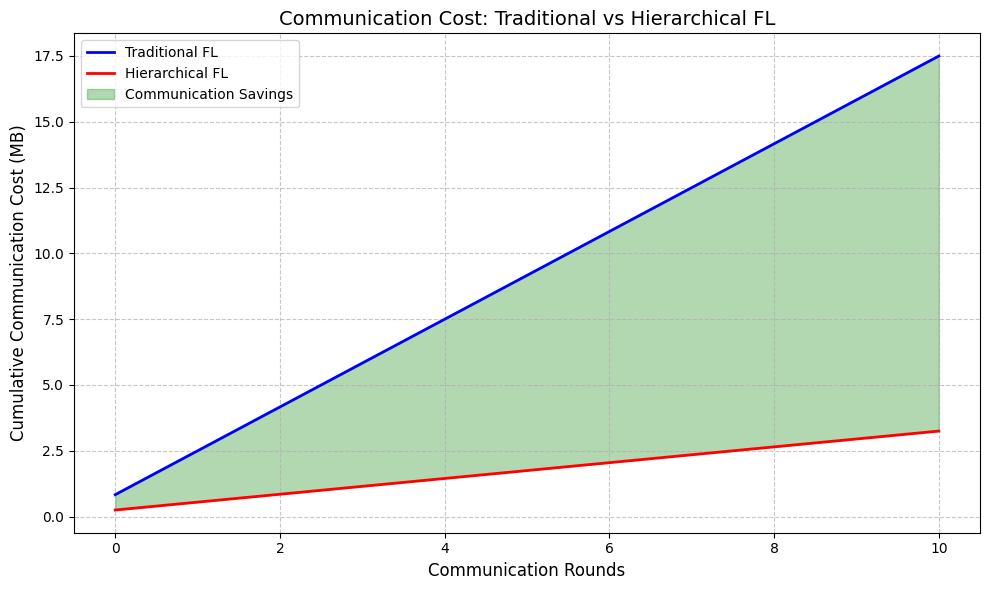

In [12]:
def plot_communication_costs(num_rounds=10):
    """
    Plot cumulative communication costs comparing Traditional FL vs Hierarchical FL
    """
    # Model parameters
    total_params = 21840  # Total model parameters
    bytes_per_param = 4   # Float32
    compression_ratio = 5  # Huffman compression
    num_clients = 10      # Traditional FL clients
    num_clusters = 3      # Hierarchical FL clusters
    
    # Calculate per-round costs
    traditional_costs = []
    hierarchical_costs = []
    cumulative_trad = 0
    cumulative_hier = 0
    
    # Initial costs
    trad_initial = num_clients * total_params * bytes_per_param  # Initial model to all clients
    hier_initial = (num_clusters * total_params * bytes_per_param) + \
                  (num_clients * 11)  # Initial model to clusters + clustering metadata
    
    cumulative_trad += trad_initial
    cumulative_hier += hier_initial
    
    traditional_costs.append(cumulative_trad / (1024 * 1024))  # Convert to MB
    hierarchical_costs.append(cumulative_hier / (1024 * 1024))
    
    # Per round costs
    for round in range(1, num_rounds + 1):
        # Traditional FL: full model updates both ways for all clients
        trad_round = num_clients * total_params * bytes_per_param * 2
        cumulative_trad += trad_round
        
        # Hierarchical FL: compressed updates from heads + full model back
        hier_round = (num_clusters * total_params * bytes_per_param / compression_ratio) + \
                    (num_clusters * total_params * bytes_per_param)
        cumulative_hier += hier_round
        
        traditional_costs.append(cumulative_trad / (1024 * 1024))
        hierarchical_costs.append(cumulative_hier / (1024 * 1024))
    
    # Create plot
    plt.figure(figsize=(10, 6))
    rounds = range(num_rounds + 1)
    
    # Plot cumulative costs
    plt.plot(rounds, traditional_costs, 'b-', label='Traditional FL', linewidth=2)
    plt.plot(rounds, hierarchical_costs, 'r-', label='Hierarchical FL', linewidth=2)
    
    # Fill area between curves to show savings
    plt.fill_between(rounds, traditional_costs, hierarchical_costs, 
                    color='green', alpha=0.3, label='Communication Savings')
    
    # Add labels and title
    plt.xlabel('Communication Rounds', fontsize=12)
    plt.ylabel('Cumulative Communication Cost (MB)', fontsize=12)
    plt.title('Communication Cost: Traditional vs Hierarchical FL', fontsize=14)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=10)
    
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Return statistics
    return {
        'traditional_final_cost': traditional_costs[-1],
        'hierarchical_final_cost': hierarchical_costs[-1],
        'per_round_costs': {
            'traditional': traditional_costs,
            'hierarchical': hierarchical_costs
        }
    }

stats = plot_communication_costs(num_rounds=10)